# AI4PH Data Challenge

Summer 2024

**Yves Nsoga** 
- PhD Candidate Biomedical Engineering
- University of Calgary
- [Data Intelligence for Health Lab](https://cumming.ucalgary.ca/dih)    

In [3]:
#packages import 

import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import os

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import imutils
from skimage import io, transform

from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
import captum
from captum.attr import visualization as viz

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import NoiseTunnel

# Data Preprocessing

process images before training.

- *stich_image*: stiches images to remove duplicates features, and generate a panoramic view
- *crop*: crop  the biggest rectangle without zero pixels
- *generate_panorama*: stiches and crop  images.


In [4]:
# Util functions

def stich_image(img_paths: list):
    """stich images with  overlaping to  generate a panoramic view of the POstal  code

    :param img_paths: a list  of image paths
    return panoramic_image
    """
    imgs = []
    for img_path in img_paths:
        img = cv2.imread(img_path)
        imgs.append(img)
    stitchy = cv2.createStitcher() if imutils.is_cv3() else cv2.Stitcher_create()
    (dummy, stiched_output) = stitchy.stitch(imgs)
    if dummy == cv2.STITCHER_OK:
        return stiched_output
    
def crop(stitched: np.array):
    """crop stiched image

    :param image: Image to resize
    :param dimension:  Expected (width, height) of new image, defaults to (800,250)
    :Returns image: Resized image
    """
    stitched = cv2.copyMakeBorder(stitched, 10, 10, 10, 10,
			cv2.BORDER_CONSTANT, (0, 0, 0))
    # convert the stitched image to grayscale and threshold it
    # such that all pixels greater than zero are set to 255
    # (foreground) while all others remain 0 (background)
    gray = cv2.cvtColor(stitched,cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]
	# find all external contours in the threshold image then find
	# the *largest* contour which will be the contour/outline of
	# the stitched image
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
	# allocate memory for the mask which will contain the
	# rectangular bounding box of the stitched image region
    mask = np.zeros(thresh.shape, dtype="uint8")
    (x, y, w, h) = cv2.boundingRect(c)
    cv2.rectangle(mask, (x, y), (x + w, y + h), 255, -1)
    minRect = mask.copy()
    sub = mask.copy()
	# keep looping until there are no non-zero pixels left in the
	# subtracted image
    while cv2.countNonZero(sub) > 0:
		# erode the minimum rectangular mask and then subtract
		# the thresholded image from the minimum rectangular mask
		# so we can count if there are any non-zero pixels left
        minRect = cv2.erode(minRect, None)
        sub = cv2.subtract(minRect, thresh)
    cnts = cv2.findContours(minRect.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    (x, y, w, h) = cv2.boundingRect(c)
	# use the bounding box coordinates to extract the our final
	# stitched image
    stitched = stitched[y:y + h, x:x + w]
    return stitched



def generate_panorama(root_folder):
    """
    """
    postal_codes = os.listdir(root_folder)
    for index, postal_code in enumerate(postal_codes):
        print(f"**** starting processing postal  code {postal_code} images")
        image_list=[]
        image_path = os.path.join(root_folder,
                                postal_codes[index])

        try:
            for images in os.listdir(image_path):
                # Selecting only horizontal images remove +'_0' to  use all  12 images,  but this might not work  for all images
                if (images.endswith(".png") and images.startswith(postal_code+'_0')):
                    image_list.append(os.path.join(image_path,
                                                images))
            panorama_view = stich_image(image_list)
            panorama_view_cropped = crop(panorama_view)
            cv2.imwrite(os.path.join(image_path,
                        "pano_view.png"), panorama_view_cropped)
            print(f"*** processing postal code {postal_code} images done ")
        except Exception as e:
            print(f"stiching of Images of postal code:{postal_code} failed, causes:{e}")
                

# Pytorch  utils functions

functions used during the training 
- *zone_panorama_dataset*: Custom dataset loader for pytorch
- *ToTensor*: Convert and normalize image
- *Resize*: Resize Image
- *Augment*: Apply augmentation to image
- *Pad*: Pad image by adding pixels with zero intenisty
 


In [22]:
class zone_panorama_dataset(Dataset):
    """
    """

    def __init__(self, csv_file, root_dir, transform=None):
        """_summary_

        :param csv_file: _description_
        :type csv_file: _type_
        :param root_dir: _description_
        :type root_dir: _type_
        :param transform: _description_, defaults to None
        :type transform: _type_, optional
        """
        self.depravation_indices_data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        postal_codes = os.listdir(self.root_dir)

        for postal_code in postal_codes:
            image_path = os.path.join(self.root_dir,
                                      postal_code)

            try:
                if os.path.exists(os.path.join(image_path, "pano_view.png")):
                    image = io.imread(os.path.join(
                        image_path, "pano_view.png"))
                    sample = {"image": image,
                              "POSTAL": postal_code,
                              "SCOREMAT": self.depravation_indices_data["SCOREMAT"].loc[self.depravation_indices_data["POSTALCODE_15"] == postal_code].values[0],
                              "SCORESOC": self.depravation_indices_data["SCORESOC"].loc[self.depravation_indices_data["POSTALCODE_15"] == postal_code].values[0]}
                    if self.transform:
                        sample = self.transform(sample)
                    self.samples.append(sample)
            except Exception as e:
                print(e)
                pass

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
        return self.samples[index]


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image = sample['image']
        score_mat = np.asarray([sample["SCOREMAT"]])
        score_soc = np.asarray([sample["SCORESOC"]])

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        trans = transforms.ToTensor()
        sample['image'] = trans(image)
        sample["SCOREMAT"] = torch.from_numpy(score_mat)
        sample["SCORESOC"] = torch.from_numpy(score_soc)
        return sample


class Resize(object):
    """Convert ndarrays in sample to Tensors."""

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']
        rescaled_image = transform.resize(image, self.output_size)
        sample['image'] = rescaled_image
        return sample


class Augment(object):
    """
    Apply Augmentation 
    """

    def __call__(self, sample):
        image = Image.fromarray(sample['image'])
        trans = transforms.AutoAugment(
            transforms.autoaugment.AutoAugmentPolicy.IMAGENET)
        transformed_image = trans(image)
        sample['image'] = np.array(transformed_image)
        return sample


class Pad(object):
    """
    Pad Image
    """

    def __call__(self, sample):
        img_size = sample['image'].shape
        image = Image.fromarray(sample['image'])
        trans = transforms.Pad((0, (img_size[1]-img_size[0])//2))
        transformed_image = trans(image)
        sample['image'] = np.array(transformed_image)
        return sample
    

class LeNet(nn.Module):
	def __init__(self, numChannels, classes):
		# call the parent constructor
		super(LeNet, self).__init__()
		# initialize first set of CONV => RELU => POOL layers
		self.conv1 = nn.Conv2d(in_channels=numChannels, out_channels=20,
                         kernel_size=(5, 5))
		self.relu1 = nn.ReLU()
		self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		# initialize second set of CONV => RELU => POOL layers
		self.conv2 = nn.Conv2d(in_channels=20, out_channels=50,
                         kernel_size=(5, 5))
		self.relu2 = nn.ReLU()
		self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		# initialize first (and only) set of FC => RELU layers
		self.fc1 = nn.Linear(in_features=140450, out_features=2000)
		self.relu3 = nn.ReLU()
		# initialize our softmax classifier
		self.fc2 = nn.Linear(in_features=2000, out_features=classes)

	def forward(self, x):
		# pass the input through our first set of CONV => RELU =>
		# POOL layers
		x = self.conv1(x)
		x = self.relu1(x)
		x = self.maxpool1(x)
		# pass the output from the previous layer through the second
		# set of CONV => RELU => POOL layers
		x = self.conv2(x)
		x = self.relu2(x)
		x = self.maxpool2(x)
		# flatten the output from the previous layer and pass it
		# through our only set of FC => RELU layers
		x = torch.flatten(x, 1)
		x = self.fc1(x)
		x = self.relu3(x)
		# pass the output to our softmax classifier to get our output
		# predictions
		output = self.fc2(x)
		# return the output predictions
		return output


# model = LeNet(numChannels=3,classes=1)

# Use pretrained model

model = models.wide_resnet50_2(weights=True)
# count = 0
# for child in model.children():
#   count += 1
#   if count < 9:
#     for param in child.parameters():
#         param.requires_grad = False
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.fc.in_features
# , nn.Linear(1000, 100),nn.Linear(100,1))
model.fc = nn.Sequential(nn.Linear(num_ftrs, 1, bias=False),nn.Tanh())#, nn.Linear(1024, 128, bias=False),nn.Linear(128, 1, bias=False))

/Users/yvesnsoganguimbous/miniconda3/envs/data622/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Regression

finetune a pretrained model on the dataset for a regression  use case

<Figure size 640x480 with 0 Axes>

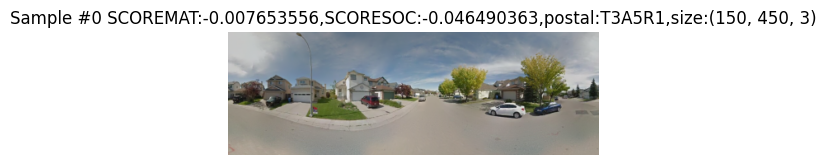

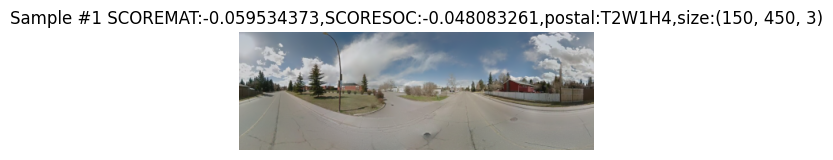

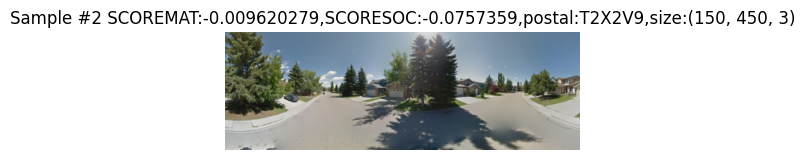

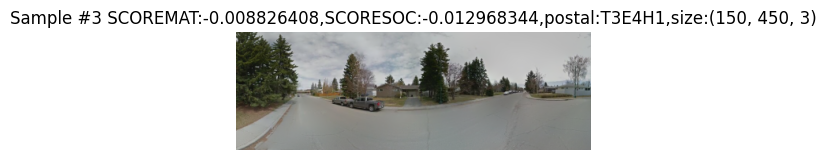

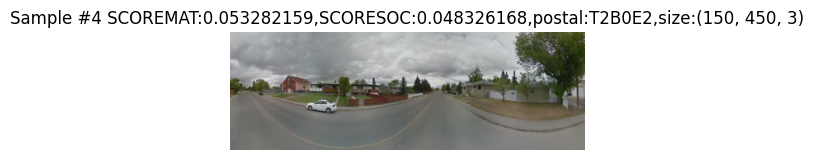

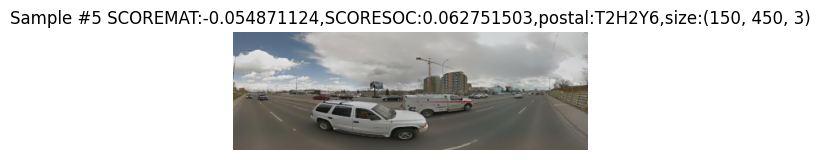

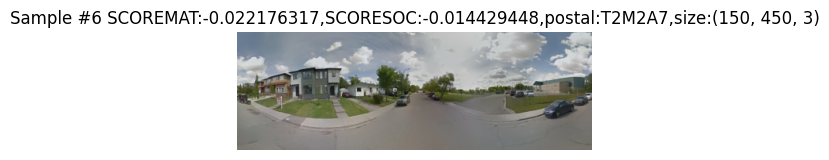

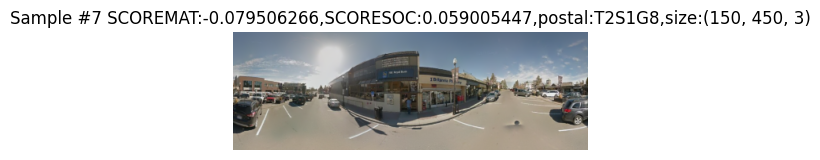

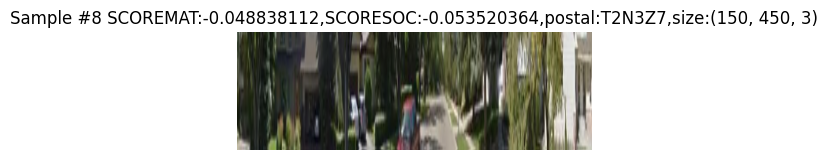

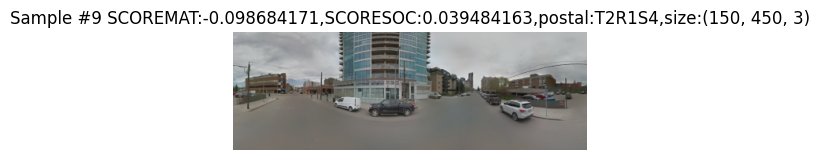

In [8]:
# Load the dataset for visualization
deprivation_dataset = zone_panorama_dataset(
    csv_file="../../Data challenge dataset_complete_no_duplication.csv", root_dir="../../GSV_Images_AB", transform=transforms.Compose([Resize((150, 450))]))
fig = plt.figure()

for i, sample in enumerate(deprivation_dataset):
    if sample:
        plt.figure(figsize=[40, 40])
        ax = plt.subplot(1, 10, i + 1)
        plt.tight_layout()
        ax.set_title(f'Sample #{i} SCOREMAT:{sample["SCOREMAT"]},SCORESOC:{sample["SCORESOC"]},postal:{sample["POSTAL"]},size:{sample["image"].shape}')
        ax.axis('off')
        ax.imshow(sample['image'])

    if i == 9:
        plt.show()
        break

In [44]:
#Load the dataset for training

deprivation_dataset_transformed = zone_panorama_dataset(
    csv_file="../../Data challenge dataset_complete_no_duplication.csv", root_dir="../../GSV_Images_AB", transform=transforms.Compose([Resize((150,450)),ToTensor()]))

In [45]:
#split the dataset into  train and test set and generate train and validation loaders
train_set, val_set = torch.utils.data.random_split(
    deprivation_dataset_transformed, [0.7, 0.3])
train_loader = DataLoader(train_set, batch_size=100,
                          shuffle=True, num_workers=0)
test_loader = DataLoader(val_set, batch_size=1,
                         shuffle=True, num_workers=0)

In [46]:
#Fine tune the model

criterion = nn.MSELoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
model.train()
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        mat_score = data["SCOREMAT"].float()
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(data["image"].float())
        loss = criterion(outputs, mat_score)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()*data["SCOREMAT"].size(0)
    print(f'[epoch:{epoch + 1}] loss: {running_loss/len(train_loader):.3f}')
print('Finished Training')

[epoch:1] loss: 95.609


In [39]:
# Evaluate the model
predictions = []
scores = []
print("Evaluating The model")
model.eval()
for i, data in enumerate(test_loader, 0):
    score = data["SCORESOC"]
    prediction = model(data["image"].float())
    error = criterion(score, prediction)
    scores.append(score.item())
    predictions.append(prediction.item())

print(f'R-squared (R²) Score: {r2_score(scores, predictions)}')

Evaluating The model
R-squared (R²) Score: -3.3595995569581767


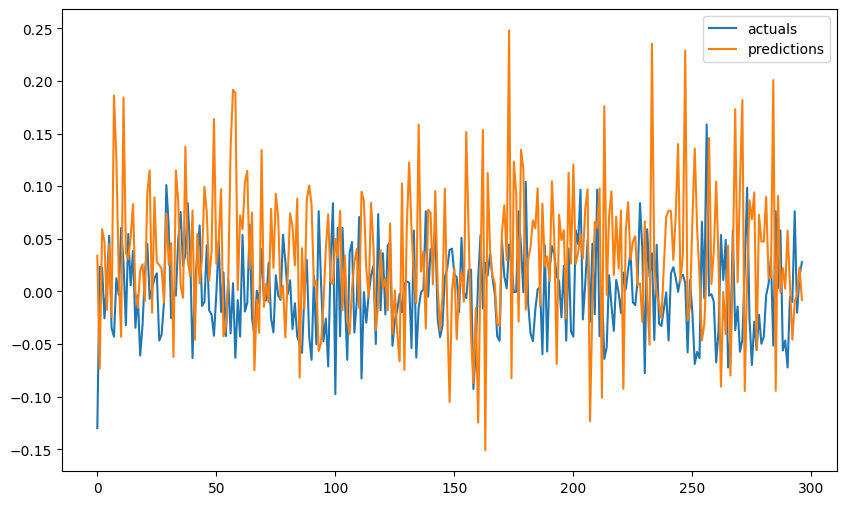

In [40]:
#Visualize the predictions and actual  scores
plot_data = pd.DataFrame({"predictions":predictions,"actual":scores})
plt.figure(figsize=(10, 6))
plt.plot(plot_data["actual"], label='actuals')
plt.plot(plot_data["predictions"], label='predictions')
plt.legend()
plt.show()

# Classification
Finetune a pretrained model for a classification use case

In [ ]:
# Convert continous variable to  category
label_encoder1 = LabelEncoder()
label_encoder2 = LabelEncoder()
deprevation_cv = pd.read_csv(
    "../Data challenge dataset_complete_no_duplication.csv")
deprevation_cv["SCOREMAT"] = label_encoder1.fit_transform(
    pd.cut(deprevation_cv["SCOREMAT"], 4, retbins=True, labels=["low", "medium_low", "medium_high", "high"])[0])
deprevation_cv["SCORESOC"] = label_encoder2.fit_transform(
    pd.cut(deprevation_cv["SCORESOC"], 4, retbins=True, labels=["low", "medium_low", "medium_high", "high"])[0])
deprevation_cv.to_csv(
    "../Data challenge dataset_complete_no_duplication_classification.csv")

In [5]:
# Use pretrained model
class_model = models.resnet50(weights=True)
for param in class_model.parameters():
    param.requires_grad = False
num_ftrs = class_model.fc.in_features

class_model.fc = nn.Sequential(nn.Linear(num_ftrs, 4), nn.Softmax(dim=1))

/Users/yvesnsoganguimbous/miniconda3/envs/data622/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
#Load the dataset
depravation_dataset_class= zone_panorama_dataset(
    csv_file="../Data challenge dataset_complete_no_duplication_classification.csv", root_dir="../GSV_Images_AB", transform=transforms.Compose([Resize((45,45)),  ToTensor()]))

In [7]:
#Split the dataset
train_set_class, val_set_class = torch.utils.data.random_split(
    depravation_dataset_class, [0.7, 0.3])
train_loader_class = DataLoader(train_set_class, batch_size=100,
                          shuffle=True, num_workers=0)
test_loader_class = DataLoader(val_set_class, batch_size=100,
                         shuffle=True, num_workers=0)

In [8]:
#train the model
criterion_2 = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(class_model.parameters(
), lr=0.001, weight_decay=0.0, momentum=0.9)
loss_history = []
accuracy_history = []
class_model.train()
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    total = 0.0
    correct = 0.0
    for i, data in enumerate(train_loader_class, 0):
        # get the inputs; data is a list of [inputs, labels]
        mat_score = data["SCORESOC"][:, 0]
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = class_model(data["image"].float())
        loss = F.nll_loss(outputs.log(), mat_score)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, axis=1)
        running_loss += loss.item()
        total += mat_score.size(0)
        correct += (predicted == mat_score).sum().item()
        
        # Print statistics
        print('[epoch: %d, batch: %5d] loss: %.3f' % (epoch + 1, i + 1 + i % 10, running_loss / 100))
        print('Accuracy of the model on the %d images: %.2f %%' % (total, 100 * correct / total))
        loss_history.append(running_loss / 100)
        accuracy_history.append(100 * correct / total)
        running_loss = 0.0
        total = 0.0
        correct = 0.0

[epoch: 1, batch:     1] loss: 0.015
Accuracy of the model on the 100 images: 11.00 %
[epoch: 1, batch:     3] loss: 0.014
Accuracy of the model on the 100 images: 26.00 %
[epoch: 1, batch:     5] loss: 0.013
Accuracy of the model on the 100 images: 37.00 %
[epoch: 1, batch:     7] loss: 0.012
Accuracy of the model on the 100 images: 49.00 %
[epoch: 1, batch:     9] loss: 0.011
Accuracy of the model on the 100 images: 46.00 %
[epoch: 1, batch:    11] loss: 0.011
Accuracy of the model on the 100 images: 56.00 %
[epoch: 1, batch:    13] loss: 0.009
Accuracy of the model on the 96 images: 56.25 %
[epoch: 2, batch:     1] loss: 0.009
Accuracy of the model on the 100 images: 54.00 %
[epoch: 2, batch:     3] loss: 0.009
Accuracy of the model on the 100 images: 55.00 %
[epoch: 2, batch:     5] loss: 0.011
Accuracy of the model on the 100 images: 57.00 %
[epoch: 2, batch:     7] loss: 0.012
Accuracy of the model on the 100 images: 45.00 %
[epoch: 2, batch:     9] loss: 0.012
Accuracy of the mo

In [9]:
#evaluate the model
class_model.eval()
test_loss = 0
correct = 0    
with torch.no_grad():
        for i, data in enumerate(test_loader_class, 0):
            mat_score = data["SCORESOC"][:, 0]
            output = class_model(data["image"].float())
            test_loss += F.nll_loss(output.log(), mat_score).item()  # sum up batch loss
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(mat_score.view_as(pred)).sum().item()

test_loss /= len(test_loader_class.dataset)
print(
    f"\nTest set: Average loss: {test_loss:.4f},"
    f" Accuracy: {correct}/{len(test_loader_class.dataset)}"
    f" ({100.0 * correct / len(test_loader_class.dataset):.0f}%)\n"
)


Test set: Average loss: 0.0100, Accuracy: 168/297 (57%)



# Model Explainability

https://captum.ai/tutorials/CIFAR_TorchVision_Interpret

In [60]:

Xplainloader = DataLoader(val_set_class, batch_size=1,
                               shuffle=False, num_workers=0)



In [66]:
image = next(iter(Xplainloader))

In [67]:
idx_to_labels ={"1":"low","2":"medium_low","3":"medium_high","4":"high"}

In [68]:
output = class_model(image["image"].float())
prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())]
label = idx_to_labels[str(image['SCORESOC'].item())]
print(f"Label:{label}, Predicted: {predicted_label}, ( {prediction_score.squeeze().item()} )")

Label:medium_high, Predicted: medium_low, ( 0.5863574743270874 )


In [69]:
# A generic function that will be used for calling attribute on attribution algorithm defined in input.
def attribute_image_features(algorithm, input, **kwargs):
    class_model.zero_grad()
    tensor_attributions = algorithm.attribute(image["image"].float(),
                                              target=image["SCORESOC"],
                                              **kwargs
                                              )

    return tensor_attributions

Computes gradients with respect to class ind and transposes them for visualization purposes.

In [70]:
saliency = Saliency(class_model)
grads = saliency.attribute(
    image["image"].float(), target=image["SCORESOC"].item())
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

/Users/yvesnsoganguimbous/miniconda3/envs/data622/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


Integrated Gradients computes the integral of the gradients of the output prediction for the class index ind with respect to the input image pixels.

In [18]:
ig = IntegratedGradients(class_model)
attr_ig, delta = attribute_image_features(
    ig, image["image"].float(), baselines=image["image"].float() * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

Approximation delta:  tensor([0.0387], dtype=torch.float64)


Below isnoise tunnel with smoothgrad square option,  adds gaussian noise with a standard deviation of stdevs=0.2 to the input image nt_samples times, computes the attributions for nt_samples images and returns the mean of the squared attributions across nt_samples images.

In [19]:
ig = IntegratedGradients(class_model)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(nt, image["image"].float(), baselines=image["image"].float() * 0, nt_type='smoothgrad_sq',
                                      nt_samples=100, stdevs=0.2)
attr_ig_nt = np.transpose(attr_ig_nt.squeeze(
    0).cpu().detach().numpy(), (1, 2, 0))

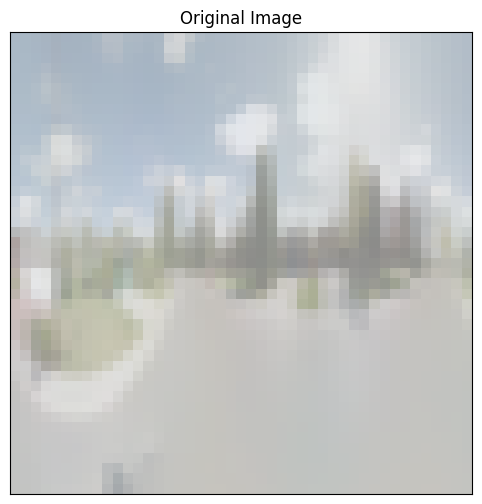

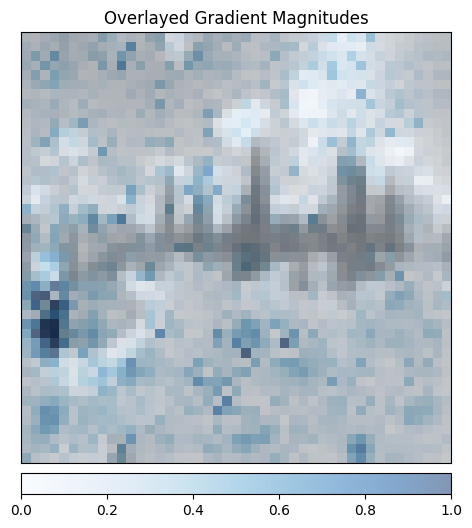

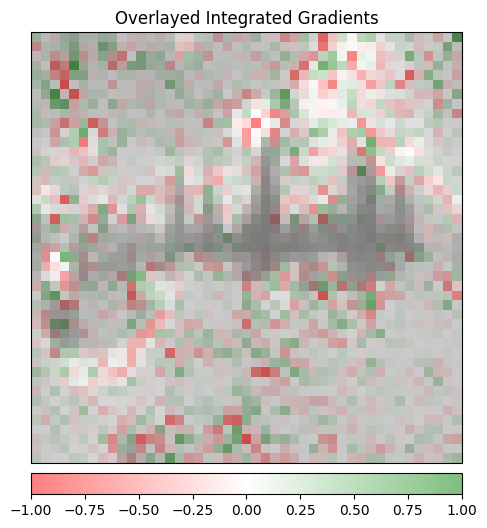

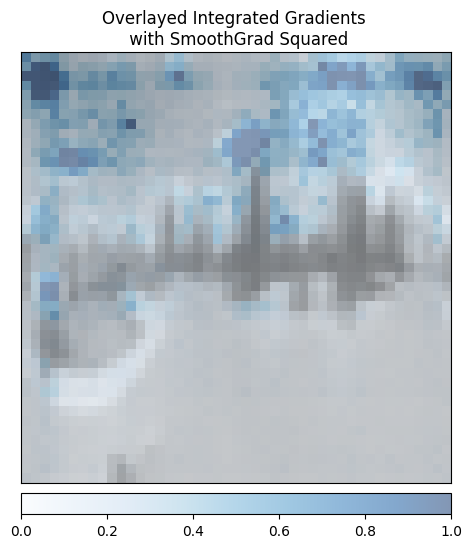

In [22]:
original_image = np.transpose(
    (image["image"].float()[0].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_ = viz.visualize_image_attr(None, original_image,
                             method="original_image", title="Original Image")

_ = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                             show_colorbar=True, title="Overlayed Gradient Magnitudes")

_ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map", sign="all",
                             show_colorbar=True, title="Overlayed Integrated Gradients")

_ = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map", sign="absolute_value",
                             outlier_perc=10, show_colorbar=True,
                             title="Overlayed Integrated Gradients \n with SmoothGrad Squared")
